In [62]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [63]:
data = pd.read_csv('./train.csv')


In [ ]:
data.head()


In [70]:
data = np.array(data)
rows,cols = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:cols] 

data_train = data[1000:rows].T
Y_train = data_train[0]
X_train = data_train[1:cols]

X_dev = X_dev / 255.0
X_train = X_train / 255.0

In [86]:
def init_params():
    W1 = np.random.randn(10, 784) * np.sqrt(2. / 784)
    b1 = np.zeros((10, 1))
    W2 = np.random.randn(10, 10) * np.sqrt(2. / 10)
    b2 = np.zeros((10, 1))

    return W1, b1, W2, b2

def init_adam_params(W1_shape, W2_shape):
    v1 = np.zeros(W1_shape)
    s1 = np.zeros(W1_shape)
    v2 = np.zeros(W2_shape)
    s2 = np.zeros(W2_shape)
    t = 0  

    return v1, s1, v2, s2, t



def LeakyReLU(Z):
    return np.maximum(0.01*Z, Z)

def softmax(Z):
    Z_exp = np.exp(Z - np.max(Z, axis=0, keepdims=True))  
    return Z_exp / np.sum(Z_exp, axis=0, keepdims=True)


def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = LeakyReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)

    return Z1, A1, Z2, A2

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T

    return one_hot_Y

def deriv_LeakyReLU(Z):
    return Z > 0

def back_prop(Z1, A1, Z2, A2, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = W2.T.dot(dZ2) * deriv_LeakyReLU(Z1)

    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)


    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2

    return W1, b1, W2, b2

def update_params_with_adam(W1, b1, W2, b2, dW1, db1, dW2, db2, t, alpha, beta1, beta2, epsilon, v1, s1, v2, s2):
    t += 1
    
    v1 = beta1 * v1 + (1 - beta1) * dW1
    v2 = beta1 * v2 + (1 - beta1) * dW2

    s1 = beta2 * s1 + (1 - beta2) * (dW1 ** 2)
    s2 = beta2 * s2 + (1 - beta2) * (dW2 ** 2)

    v1_hat = v1 / (1 - beta1 ** t)
    v2_hat = v2 / (1 - beta1 ** t)

    s1_hat = s1 / (1 - beta2 ** t)
    s2_hat = s2 / (1 - beta2 ** t)

    W1 -= alpha * v1_hat / (np.sqrt(s1_hat) + epsilon)
    b1 -= alpha * db1  
    W2 -= alpha * v2_hat / (np.sqrt(s2_hat) + epsilon)
    b2 -= alpha * db2  

    return W1, b1, W2, b2, v1, s1, v2, s2, t






In [90]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size


initial_alpha = 0.01
beta1 = 0.9  
beta2 = 0.999 
epsilon = 1e-8 
def gradient_descent(X, Y, iteration, alpha):
    W1, b1, W2, b2 = init_params()

    v1, s1, v2, s2, t = init_adam_params(W1.shape, W2.shape)

    for i in range(iteration):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W2, X, Y)
        alpha = initial_alpha / (1 + 0.001 * i)  

        W1, b1, W2, b2, v1, s1, v2, s2, t = update_params_with_adam( W1, b1, W2, b2, dW1, db1, dW2, db2, t, alpha, beta1, beta2, epsilon, v1, s1, v2, s2)
        if i % 100 == 0:
            print("Iteration: ", i)
            print("Accuracy: ", get_accuracy(get_predictions(A2), Y))
    return W1, b1, W2, b2


In [89]:


W1, b1, W2, b2 = gradient_descent(X_train, Y_train,500, 0.01)

Iteration:  0
Accuracy:  0.08119512195121951
Iteration:  100
Accuracy:  0.9282439024390244
Iteration:  200
Accuracy:  0.9416829268292682
Iteration:  300
Accuracy:  0.9482682926829268
Iteration:  400
Accuracy:  0.9521951219512195


In [99]:
def make_prediction(X, W1, b1, W2, b2):
    Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:,index, None]
    prediction = make_prediction(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()
    

Prediction:  [1]
Label:  1


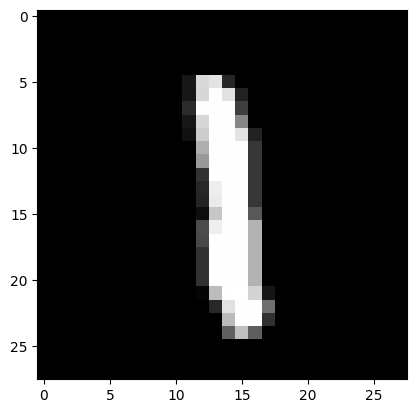

In [100]:
test_prediction(220, W1, b1, W2, b2)